In [6]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

In [7]:
class CustomVOCImageDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def parse_voc_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        objects = []
        for obj in root.findall("object"):
            obj_name = obj.find("name").text
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Lấy kích thước của ảnh gốc từ file annotation
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            # Chuẩn hóa bounding box về khoảng [0, 1]
            xmin_norm = xmin / width
            ymin_norm = ymin / height
            xmax_norm = xmax / width
            ymax_norm = ymax / height

            objects.append({"name": obj_name, "bndbox": [xmin_norm, ymin_norm, xmax_norm, ymax_norm]})
        return objects


    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        xml_filename = img_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(self.annotations_dir, xml_filename)

        if not os.path.exists(xml_path):
            raise FileNotFoundError(f"Annotation file {xml_path} not found.")

        labels = self.parse_voc_xml(xml_path)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            labels = self.target_transform(labels)

        return image, labels




In [8]:
def draw_boxes(image, labels):
    """
    Vẽ các bounding boxes và nhãn lên hình ảnh đã resize.
    Các tọa độ đã chuẩn hóa sẽ được nhân lại với kích thước ảnh để chuyển về pixel.
    """
    draw = ImageDraw.Draw(image)
    resized_width, resized_height = image.size  # Kích thước ảnh đã resize

    for label in labels:
        bndbox = label["bndbox"]
        xmin = int(bndbox[0] * resized_width)
        ymin = int(bndbox[1] * resized_height)
        xmax = int(bndbox[2] * resized_width)
        ymax = int(bndbox[3] * resized_height)

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin), label["name"], fill="red")
    return image

In [9]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return torch.stack(images, 0), targets


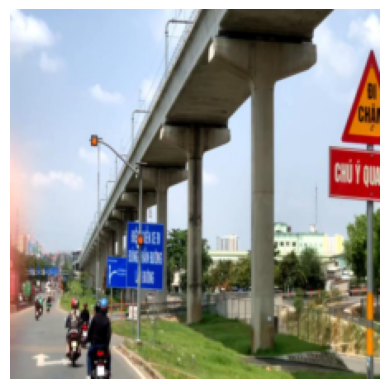

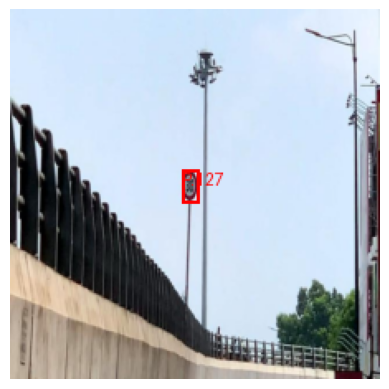

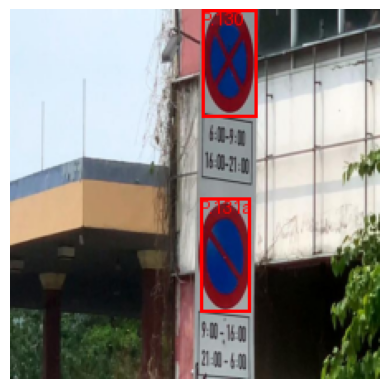

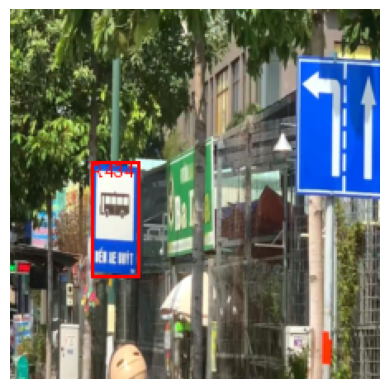

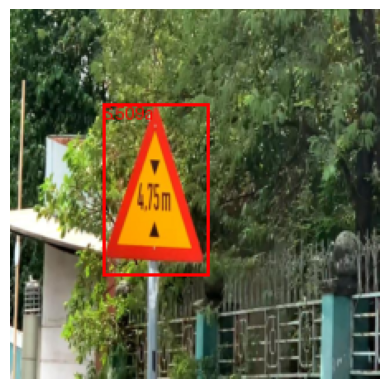

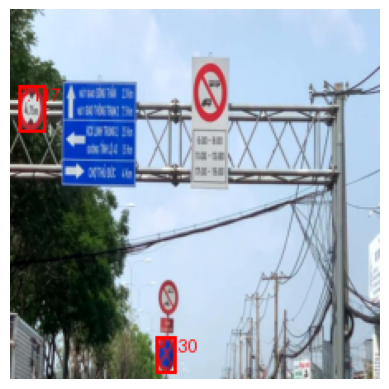

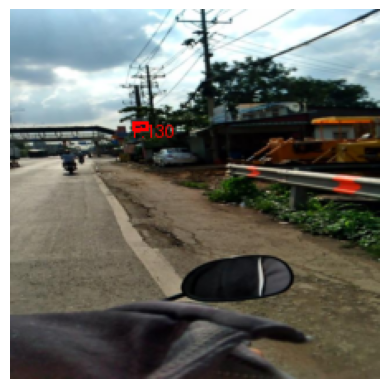

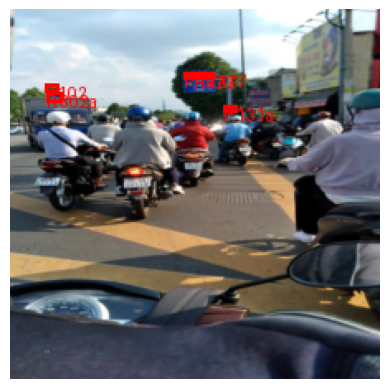

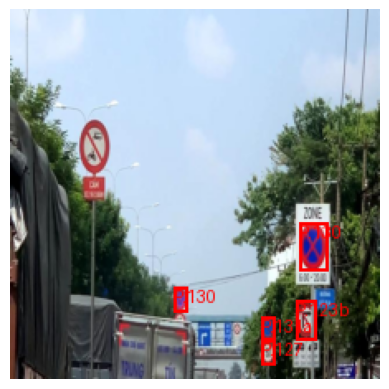

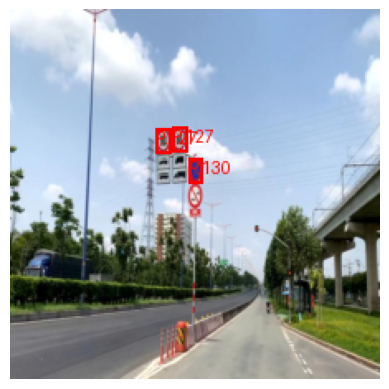

Batch 1: 10 images, Labels: ([], [{'name': 'P.127', 'bndbox': [0.4671875, 0.434375, 0.5109375, 0.5234375]}], [{'name': 'P.130', 'bndbox': [0.51875, 0.0015625, 0.6671875, 0.29375]}, {'name': 'P.131a', 'bndbox': [0.5140625, 0.5125, 0.6515625, 0.8171875]}], [{'name': 'R.434', 'bndbox': [0.21875, 0.4140625, 0.3484375, 0.7234375]}], [{'name': 'S.509a', 'bndbox': [0.2515625, 0.2546875, 0.5359375, 0.71875]}], [{'name': 'P.130', 'bndbox': [0.396875, 0.884375, 0.45, 0.9828125]}, {'name': 'P.117', 'bndbox': [0.0234375, 0.209375, 0.09375, 0.33125]}], [{'name': 'P.130', 'bndbox': [0.334375, 0.3046875, 0.371875, 0.328125]}], [{'name': 'P.127', 'bndbox': [0.46875, 0.1734375, 0.4953125, 0.1890625]}, {'name': 'P.127', 'bndbox': [0.4984375, 0.171875, 0.5234375, 0.1875]}, {'name': 'P.127', 'bndbox': [0.528125, 0.171875, 0.553125, 0.1875]}, {'name': 'P.131a', 'bndbox': [0.5796875, 0.259375, 0.6125, 0.2796875]}, {'name': 'P.102', 'bndbox': [0.096875, 0.203125, 0.1328125, 0.2265625]}, {'name': 'R.302a', 'b

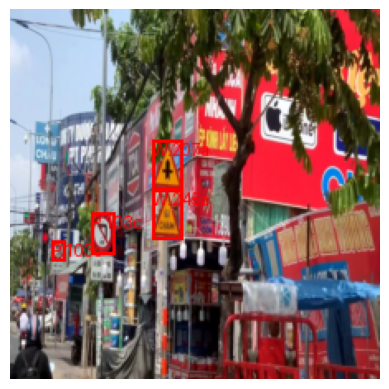

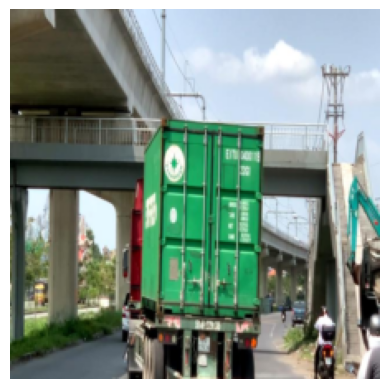

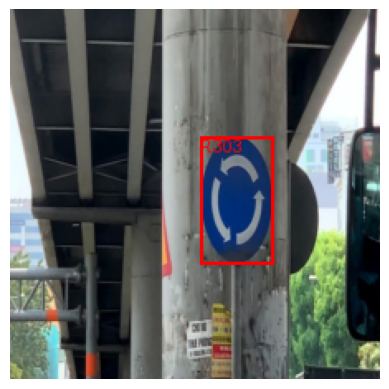

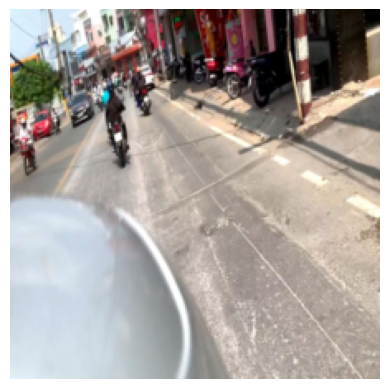

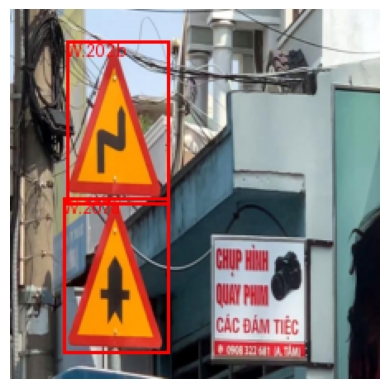

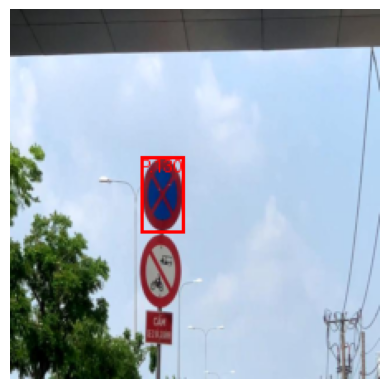

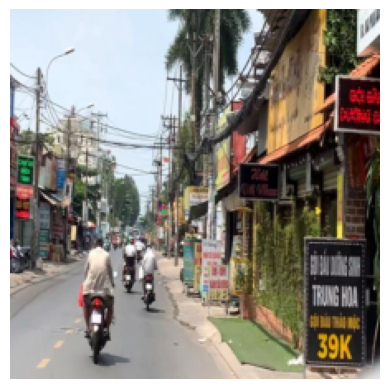

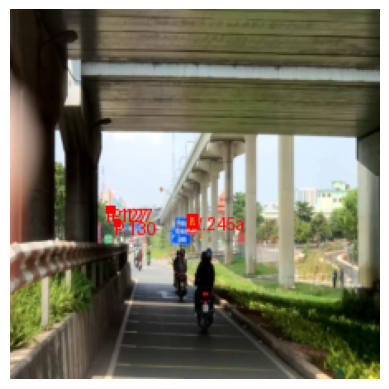

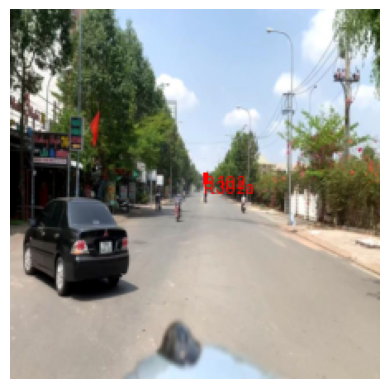

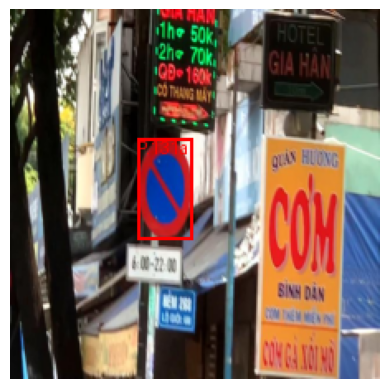

Batch 2: 10 images, Labels: ([{'name': 'W.207a', 'bndbox': [0.3859375, 0.35625, 0.465625, 0.490625]}, {'name': 'W.245a', 'bndbox': [0.384375, 0.490625, 0.465625, 0.6234375]}, {'name': 'P.103c', 'bndbox': [0.2203125, 0.55, 0.2828125, 0.6625]}, {'name': 'P.103c', 'bndbox': [0.115625, 0.625, 0.1484375, 0.6796875]}], [], [{'name': 'R.303', 'bndbox': [0.5171875, 0.34375, 0.7125, 0.690625]}], [], [{'name': 'W.202b', 'bndbox': [0.153125, 0.0859375, 0.4328125, 0.5296875]}, {'name': 'W.207a', 'bndbox': [0.146875, 0.509375, 0.4296875, 0.93125]}], [{'name': 'P.130', 'bndbox': [0.35625, 0.4, 0.4703125, 0.6046875]}], [], [{'name': 'W.245a', 'bndbox': [0.48125, 0.5546875, 0.5046875, 0.5921875]}, {'name': 'P.127', 'bndbox': [0.2625, 0.5328125, 0.2734375, 0.5515625]}, {'name': 'P.127', 'bndbox': [0.2734375, 0.534375, 0.284375, 0.5515625]}, {'name': 'P.130', 'bndbox': [0.284375, 0.5671875, 0.2953125, 0.5875]}], [{'name': 'P.102', 'bndbox': [0.5234375, 0.44375, 0.53125, 0.4578125]}, {'name': 'R.302a', '

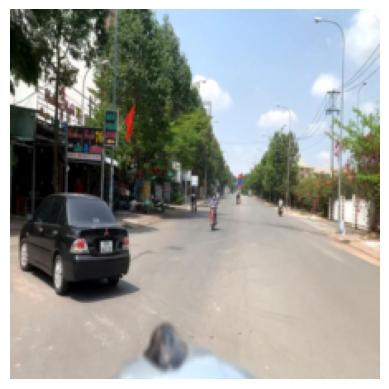

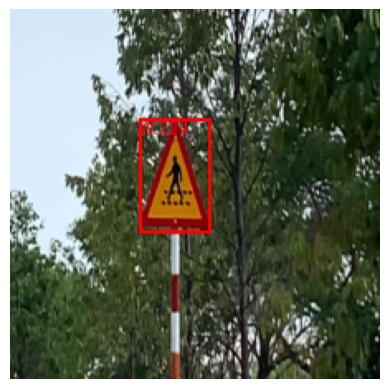

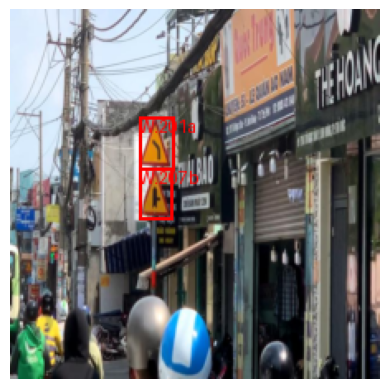

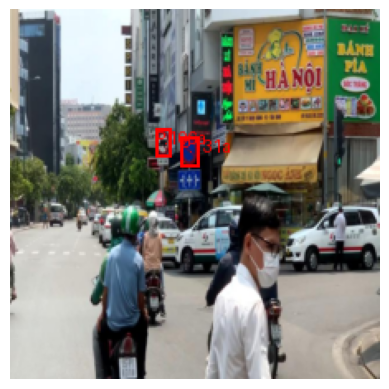

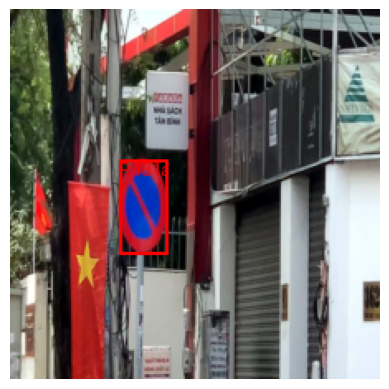

KeyboardInterrupt: 

In [10]:
if __name__ == "__main__":
    annotations_dir = "Vietnam-Traffic-Sign-Detection.v6i.voc/train/"
    img_dir = "Vietnam-Traffic-Sign-Detection.v6i.voc/train/"

    # Transform ảnh về kích thước cố định 224x224
    transform = T.Compose(
        [
            T.Resize((224, 224)),  # Resize tất cả ảnh về 224x224
            T.ToTensor(),
        ]
    )

    dataset = CustomVOCImageDataset(annotations_dir, img_dir, transform=transform)

    # Sử dụng DataLoader với hàm collate_fn
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)

    for batch_idx, (images, labels_batch) in enumerate(dataloader):
        for i in range(len(images)):
            # Chuyển đổi tensor về PIL Image để vẽ bounding boxes
            image_pil = T.ToPILImage()(images[i])

            # Vẽ bounding boxes lên ảnh đã resize
            image_pil = draw_boxes(image_pil, labels_batch[i])

            # Hiển thị hình ảnh
            plt.imshow(image_pil)
            plt.axis("off")
            plt.show()

        print(f"Batch {batch_idx + 1}: {len(images)} images, Labels: {labels_batch},")